# TMDB Movie Data Analytics

### Importing necessary libraries

In [15]:
import numpy as np                     
import pandas as pd                   
import matplotlib.pyplot as plt        
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

### Reading the clean datafiles

In [7]:
m_df = pd.read_csv('cleaned_movie_df.csv')
genres_df = pd.read_csv('genres.csv')
keywords_df = pd.read_csv('keywords.csv')
production_companies_df = pd.read_csv('production_companies.csv')
production_countries_df = pd.read_csv('production_countries.csv')
cast_df = pd.read_csv('cast.csv')
crew_df = pd.read_csv('crew.csv')

## 01. Optimal Groups for Top-Rated Movies
### K-Means Clustering
Grouping top-rated movies (vote_average > 8) into meaningful clusters to identify patterns like “low-budget short runtime” vs. “high-budget long runtime” films.

In [8]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

#### Selecting Features for Clustering

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
top_rated = m_df[m_df['vote_average'] > 8]  # selecting top-rated movies
features = ['budget', 'runtime', 'popularity', 'vote_count', 'profit']  # chosen features
X = top_rated[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Choosing Optimal k (Elbow Method)

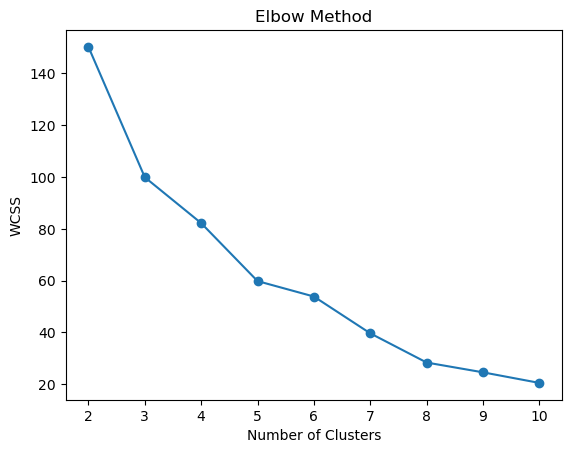

In [12]:
from sklearn.cluster import KMeans

wcss = []  # within-cluster sum of squares
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2,11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

#### Fitting Final K-Means

In [16]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
top_rated['Cluster'] = clusters

#### Visualising Clusters

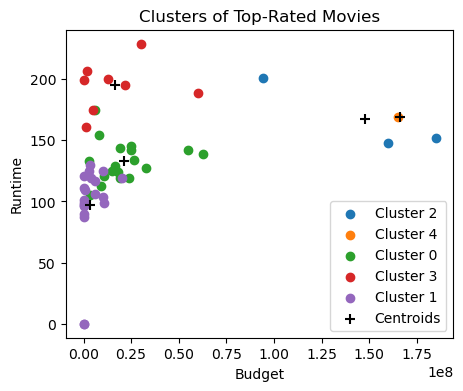

In [17]:
plt.figure(figsize=(5,4))
for c in top_rated['Cluster'].unique():
    plt.scatter(top_rated[top_rated['Cluster']==c]['budget'],
                top_rated[top_rated['Cluster']==c]['runtime'], label=f'Cluster {c}')
plt.scatter(kmeans.cluster_centers_[:,0]*X[features[0]].std() + X[features[0]].mean(),
            kmeans.cluster_centers_[:,1]*X[features[1]].std() + X[features[1]].mean(),
            c='black', marker='+', s=50, label='Centroids')
plt.xlabel('Budget')
plt.ylabel('Runtime')
plt.title('Clusters of Top-Rated Movies')
plt.legend()
plt.show()

## 02. Movie Success Classification
### K-Nearest Neighbors

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#### Predicting whether a movie will be a Hit or Flop based on features.

In [21]:
#  Defining Hit vs Flop based on revenue threshold
m_df['success'] = m_df['revenue'].apply(lambda x: 1 if x > 100000000 else 0)  
# 1 = Hit, 0 = Flop (threshold: $100M revenue)

#### Selecting Features

In [22]:
features = ['budget', 'runtime', 'vote_average', 'popularity']
X = m_df[features]
y = m_df['success']

print(y.unique())

[1 0]


#### Splitting Data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Training KNN Model

In [26]:
knn = KNeighborsClassifier(n_neighbors=5)  # start with k=5
knn.fit(X_train, y_train)

KNeighborsClassifier()

#### Prediction

In [27]:
y_pred = knn.predict(X_test)

#### Evaluation

In [28]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       730
           1       0.76      0.62      0.68       231

    accuracy                           0.86       961
   macro avg       0.82      0.78      0.80       961
weighted avg       0.86      0.86      0.86       961



#### Confusion Matrix

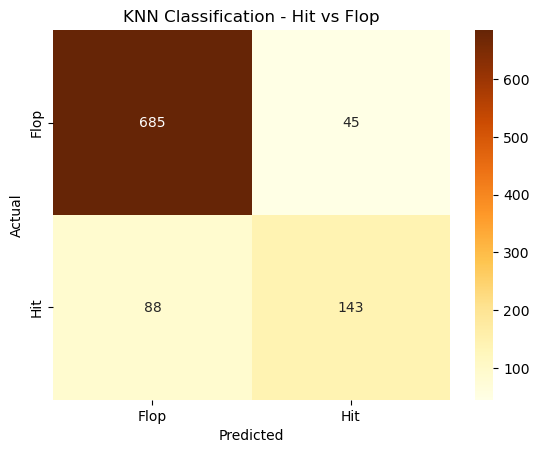

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=['Flop','Hit'], yticklabels=['Flop','Hit'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Classification - Hit vs Flop")
plt.show()